remove z limit + still apply the snr

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import json

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

get some basic info of data files

In [2]:
# ValueError: could not convert string to float: '8789-0'
def read_data_partial(given_fname, output_fname, lim=399999):
    content = []
    count = 1

    with open(given_fname, 'r') as fr:
        for line in fr:
            if count <= lim:
                #print(type(line), line)
                content.append(line)
                count += 1
    with open(output_fname, 'w') as fw:
        for line in content:
            # print(type(line), line)
            fw.write(line)
    
    data = pd.read_csv(output_fname, index_col=False)

    return data

## drop u, g, r bands

In [3]:
qso_train_partial = read_data_partial('quasar_train_catalog.csv', 'qso_train_partial.csv')
qso_train_drop = qso_train_partial[['z', 'r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
qso_train_drop = qso_train_drop.replace(99.99, np.nan).dropna()
qso_train_drop = qso_train_drop[qso_train_drop['z'] < 7.5]
qso_train_drop = qso_train_drop[(qso_train_drop['r_LSST_magerr']>0.2)&(qso_train_drop['i_LSST_magerr']>0.2)]
qso_train_drop = qso_train_drop.drop(columns=['z', 'r_LSST_magerr', 'i_LSST_magerr'])
print('qso_train_catalog_z.csv partial data description: ')
qso_train_drop.describe()

qso_train_catalog_z.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,20759.000000,20759.000000,20759.000000,20759.000000,20759.000000,20759.000000
mean,28.576193,26.616020,24.340320,24.201112,24.264969,24.132527
std,1.218340,1.654428,2.009015,2.089360,2.112093,2.108081
min,26.672280,23.064283,18.489759,17.989148,17.800595,17.633615
25%,27.689657,25.314514,23.136710,22.977195,23.069490,22.937156
50%,28.366448,26.540555,24.371926,24.306130,24.363508,24.192066
75%,29.189413,27.668971,25.789820,25.697926,25.766767,25.595761
max,38.902328,36.769079,32.115011,32.168396,32.742341,33.953075


In [4]:
# brown dwarf contaminants
mlt_train_partial = read_data_partial('mlt_train_catalog.csv', 'mlt_train_partial.csv', 599999)
mlt_train_drop = mlt_train_partial[['r_LSST_magerr', 'i_LSST_magerr', 'i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
mlt_train_drop = mlt_train_drop.replace(99.99, np.nan).dropna()
mlt_train_drop = mlt_train_drop[(mlt_train_drop['r_LSST_magerr']>0.2)&(mlt_train_drop['i_LSST_magerr']>0.2)]
mlt_train_drop = mlt_train_drop.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('mlt_train_catalog_z.csv partial data description: ')
mlt_train_drop.describe()

mlt_train_catalog_z.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,40214.000000,40214.000000,40214.000000,40214.000000,40214.000000,40214.000000
mean,27.846368,26.406966,24.814492,24.240174,23.941983,23.954949
std,0.866569,0.814599,0.652285,0.636041,0.633281,0.639802
min,26.565172,24.640153,22.966413,22.249321,21.884903,21.705643
25%,27.248302,25.848580,24.336131,23.782914,23.500752,23.511550
50%,27.631546,26.262440,24.722560,24.157117,23.877029,23.890512
75%,28.185010,26.792519,25.207176,24.619579,24.324040,24.337251
max,38.215437,36.198974,28.369839,27.735964,27.180561,27.305963


In [5]:
galaxies_patch8789_partial = read_data_partial('galaxies_train_catalog_patch8789.csv', 'galaxies_patch8789_partial.csv')
galaxies_patch8789_drop = galaxies_patch8789_partial[['r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8789_drop = galaxies_patch8789_drop.replace(99.99, np.nan).dropna()
galaxies_patch8789_drop = galaxies_patch8789_drop[(galaxies_patch8789_drop['r_LSST_magerr']>0.2)&(galaxies_patch8789_drop['i_LSST_magerr']>0.2)]
galaxies_patch8789_drop = galaxies_patch8789_drop.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('galaxies_train_catalog_patch8789.csv partial data description: ')
galaxies_patch8789_drop.describe()

galaxies_train_catalog_patch8789.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,166180.000000,166180.000000,166180.000000,166180.000000,166180.000000,166180.000000
mean,28.112741,27.507701,27.330679,27.226355,27.160891,27.154280
std,0.888656,0.950758,0.788433,0.796900,0.827853,0.977009
min,26.647539,25.462982,25.152190,24.748167,24.475726,24.258516
25%,27.518918,26.883531,26.837638,26.737179,26.657671,26.557470
50%,27.920273,27.314756,27.248012,27.172407,27.118375,27.041903
75%,28.465759,27.895376,27.710084,27.634895,27.594613,27.601858
max,40.029429,39.261958,39.647494,40.707497,38.204669,38.379259


In [6]:
galaxies_patch8786_partial = read_data_partial('galaxies_train_catalog_patch8786.csv', 'galaxies_patch8786_partial.csv')
galaxies_patch8786_drop = galaxies_patch8786_partial[['r_LSST_magerr', 'i_LSST_magerr','i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
galaxies_patch8786_drop = galaxies_patch8786_drop.replace(99.99, np.nan).dropna()
galaxies_patch8786_drop = galaxies_patch8786_drop[(galaxies_patch8786_drop['r_LSST_magerr']>0.2)&(galaxies_patch8786_drop['i_LSST_magerr']>0.2)]
galaxies_patch8786_drop = galaxies_patch8786_drop.drop(columns=['r_LSST_magerr', 'i_LSST_magerr'])
print('galaxies_train_catalog_patch8786.csv partial data description: ')
galaxies_patch8786_drop.describe()

galaxies_train_catalog_patch8786.csv partial data description: 


,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,156946.000000,156946.000000,156946.000000,156946.000000,156946.000000,156946.000000
mean,28.100839,27.494196,27.312890,27.205311,27.141593,27.131091
std,0.886168,0.952284,0.787836,0.803832,0.842035,0.981601
min,26.573603,25.553776,25.107279,24.705397,24.460871,24.280885
25%,27.507428,26.871497,26.818026,26.714657,26.633417,26.535331
50%,27.905549,27.298753,27.235470,27.156032,27.102195,27.024873
75%,28.452895,27.883019,27.697073,27.620384,27.584425,27.588162
max,40.812877,40.422024,37.436853,38.037623,37.411129,37.630643


### drop missing values

In [7]:
print(qso_train_drop.head(), len(qso_train_drop))
print(np.where(np.isnan(qso_train_drop)))
print(len(mlt_train_drop))
print(np.where(np.isnan(mlt_train_drop)))
print(len(galaxies_patch8789_drop))
print(np.where(np.isnan(galaxies_patch8789_drop)))
print(len(galaxies_patch8786_drop))
print(np.where(np.isnan(galaxies_patch8786_drop)))

      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag
1281   27.955360   23.388638  18.489759  18.079326  18.072496  18.058461
1307   27.672539   23.363093  18.584296  18.061424  18.042225  18.025975
1329   28.051408   23.778138  18.601250  18.008757  17.881144  17.780953
1344   27.538063   23.893443  18.537558  18.022577  17.954901  17.866836
1350   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758 20759
(array([], dtype=int64), array([], dtype=int64))
40214
(array([], dtype=int64), array([], dtype=int64))
166180
(array([], dtype=int64), array([], dtype=int64))
156946
(array([], dtype=int64), array([], dtype=int64))


In [8]:
qso_train_drop['label'] = np.ones(len(qso_train_drop))
mlt_train_drop['label'] = np.zeros(len(mlt_train_drop))
galaxies_patch8789_drop['label'] = np.zeros(len(galaxies_patch8789_drop))
galaxies_patch8786_drop['label'] = np.zeros(len(galaxies_patch8786_drop))

### check the cleaned datasets and concatenate into new ones

In [9]:
print('qso:\n', qso_train_drop.head())
print('bd:\n', mlt_train_drop.head())
print('galaxies patch8789:\n', galaxies_patch8789_drop.head())
print('galaxies path8786:\n', galaxies_patch8786_drop.head())

qso:
       i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
1281   27.955360   23.388638  18.489759  18.079326  18.072496  18.058461   
1307   27.672539   23.363093  18.584296  18.061424  18.042225  18.025975   
1329   28.051408   23.778138  18.601250  18.008757  17.881144  17.780953   
1344   27.538063   23.893443  18.537558  18.022577  17.954901  17.866836   
1350   27.028989   24.008393  18.589781  18.074683  17.986391  17.954758   

      label  
1281    1.0  
1307    1.0  
1329    1.0  
1344    1.0  
1350    1.0  
bd:
         i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
398247   26.888214   24.767034  24.160454  23.807130  23.455427  23.446447   
398253   26.758145   25.077703  24.012978  23.724390  23.529321  23.489750   
398350   26.817520   25.070334  24.192246  23.774151  23.644759  23.551041   
398458   26.976849   25.348521  24.372349  23.913859  23.949639  23.681874   
398464   26.788703   25.283402  24.121468  23.827350  23.8

In [10]:
# data concatenation to get training data
contaminants_drop = pd.concat([mlt_train_drop, galaxies_patch8789_drop, galaxies_patch8786_drop], ignore_index=True)
data_train_drop = pd.concat([qso_train_drop, contaminants_drop], ignore_index=True) # make sure that the data line up
data_train_drop = data_train_drop[data_train_drop['z_LSST_mag'] > 26.0]
data_train_drop = data_train_drop[data_train_drop['z_LSST_mag'] < 28.0]
X_drop = data_train_drop[['i_LSST_mag', 'z_LSST_mag','Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']]
Y_drop = data_train_drop['label']

In [11]:
print(len(X_drop))

284862


In [12]:
X_drop.describe()

,i_LSST_mag,z_LSST_mag,Y_WFI_mag,J_WFI_mag,H_WFI_mag,F_WFI_mag
count,284862.000000,284862.000000,284862.000000,284862.000000,284862.000000,284862.000000
mean,28.044604,27.077606,26.942538,26.793503,26.712608,26.708527
std,0.865132,0.482542,1.078463,1.174378,1.231886,1.325570
min,26.573603,26.000028,19.409813,18.831905,18.769795,18.799870
25%,27.467932,26.720700,26.548834,26.414199,26.314890,26.218163
50%,27.848185,27.081289,27.042002,26.960034,26.900613,26.821625
75%,28.377978,27.451289,27.504683,27.436077,27.399640,27.392085
max,40.812877,27.999999,39.647494,40.707497,36.833447,38.379259


In [13]:
col_names = ['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag']
for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i < j:
            col = col_names[i] + '-' + col_names[j]
            X_drop[col] = X_drop[col_names[i]] - X_drop[col_names[j]]

X_drop_copy = X_drop.drop(columns=['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag'])

/data0/sw/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


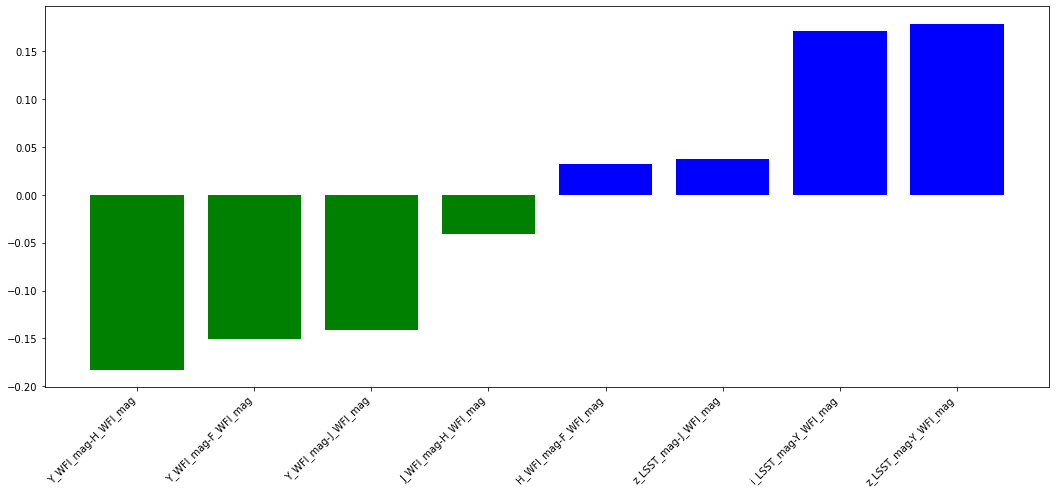

In [14]:
trainedsvm = svm.LinearSVC(max_iter = 2000).fit(X_drop_copy, Y_drop)
coef = trainedsvm.coef_.ravel()

top_positive_coefficients = np.argsort(coef)[-4:]
top_negative_coefficients = np.argsort(coef)[:4]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
plt.figure(figsize=(18, 7))
colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 4), coef[top_coefficients], color=colors)
feature_names = np.array(X_drop_copy.columns)
plt.xticks(np.arange(2 * 4), feature_names[top_coefficients], rotation=45, ha='right')
plt.show()

In [15]:
# keep the columns with the highest influences & check if the dataframes look reasonable
X_drop_copy = X_drop[['i_LSST_mag', 'z_LSST_mag', 'Y_WFI_mag', 'J_WFI_mag', 'H_WFI_mag', 'F_WFI_mag', 'Y_WFI_mag-H_WFI_mag', 'Y_WFI_mag-F_WFI_mag', 'Y_WFI_mag-J_WFI_mag', 'J_WFI_mag-H_WFI_mag', 'H_WFI_mag-F_WFI_mag', 'z_LSST_mag-J_WFI_mag', 'i_LSST_mag-Y_WFI_mag', 'z_LSST_mag-Y_WFI_mag']]

print('training data X: \n', X_drop_copy.head())

training data X: 
      i_LSST_mag  z_LSST_mag  Y_WFI_mag  J_WFI_mag  H_WFI_mag  F_WFI_mag  \
251   28.034558   26.041640  19.409813  18.831905  18.769795  18.799870   
466   29.044042   26.163572  19.929802  19.348010  19.213907  19.143379   
510   29.472714   26.098831  20.046809  19.504998  19.430129  19.412411   
513   27.942294   26.469527  20.091360  19.424318  19.320320  19.235941   
548   29.263520   26.039098  20.077260  19.575394  19.563593  19.533493   

     Y_WFI_mag-H_WFI_mag  Y_WFI_mag-F_WFI_mag  Y_WFI_mag-J_WFI_mag  \
251             0.640018             0.609943             0.577908   
466             0.715895             0.786422             0.581792   
510             0.616681             0.634398             0.541812   
513             0.771040             0.855419             0.667041   
548             0.513667             0.543767             0.501866   

     J_WFI_mag-H_WFI_mag  H_WFI_mag-F_WFI_mag  z_LSST_mag-J_WFI_mag  \
251             0.062110            -0

### color-color plots to decide which combinations should be used for decision boundaries 

check which ones are the most "separable"

In [42]:
import seaborn as sns

In [43]:
def color_plot(X, x_lab, y_lab):
    q = sns.jointplot(data=X, x=x_lab, y=y_lab, hue='label', kind='scatter', joint_kws={"alpha": 0.3})

In [44]:
X_drop_copy['label'] = Y_drop

<ipython-input-44-6ce2bc7d2b32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_drop_copy['label'] = Y_drop


/data0/sw/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1598: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


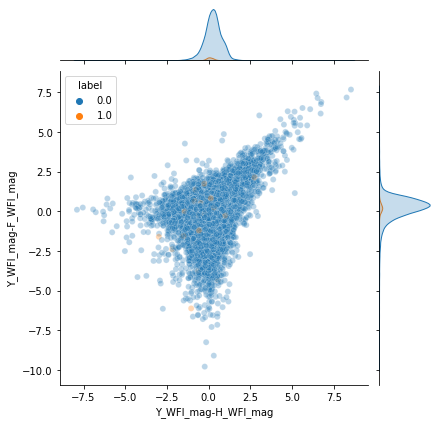

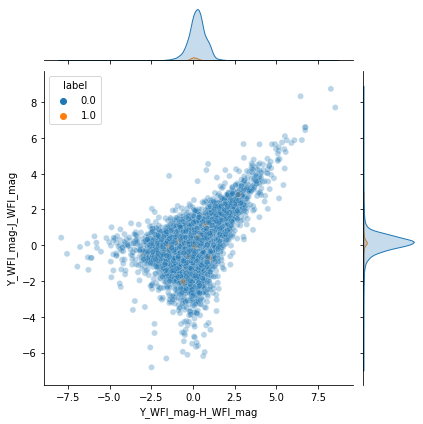

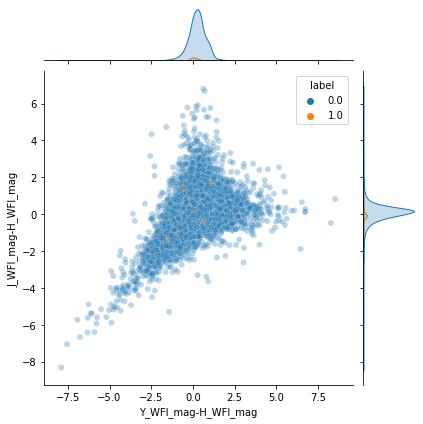

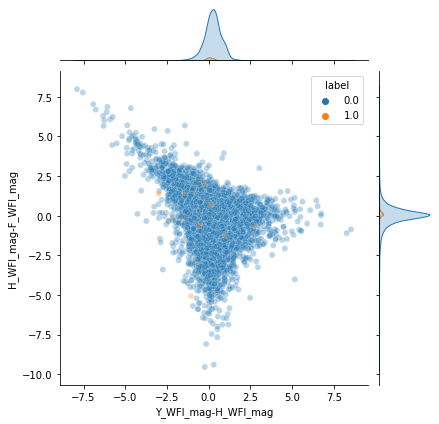

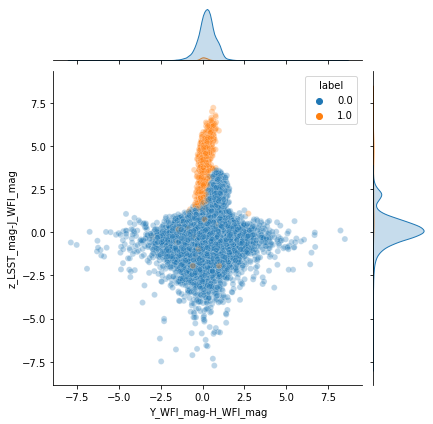

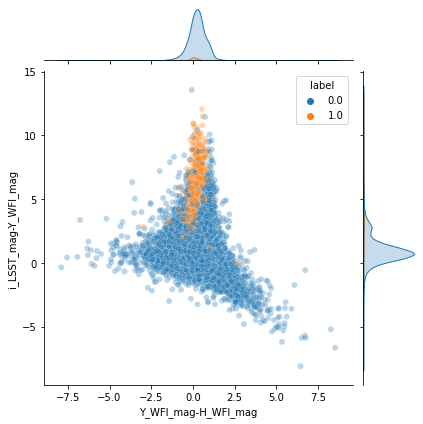

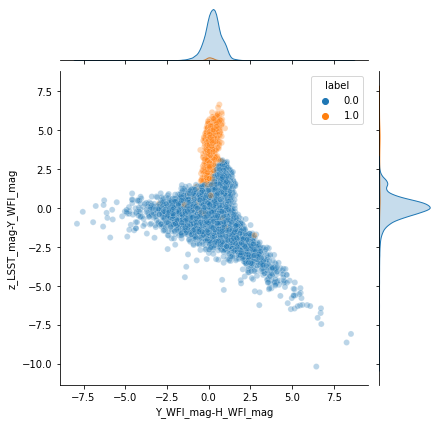

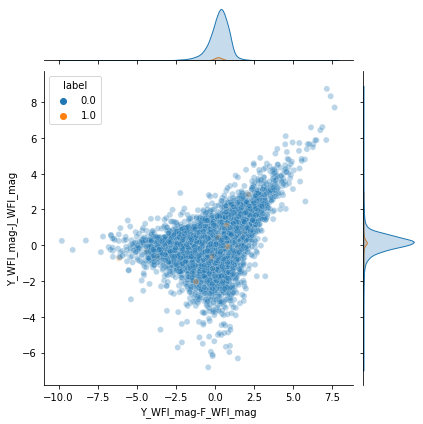

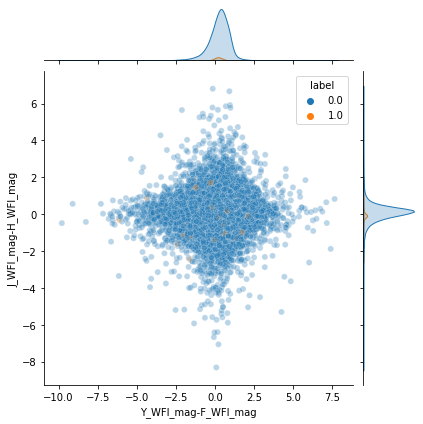

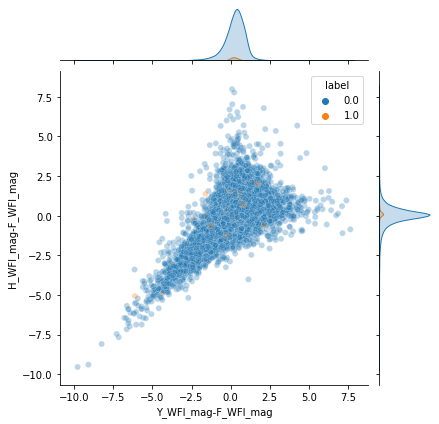

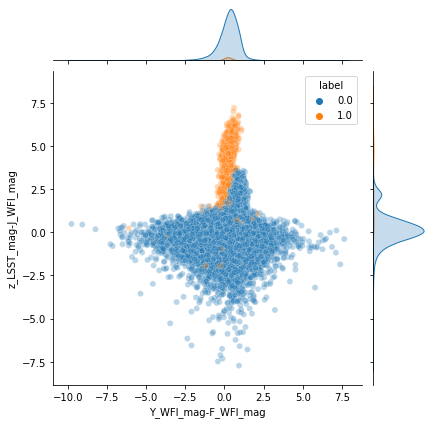

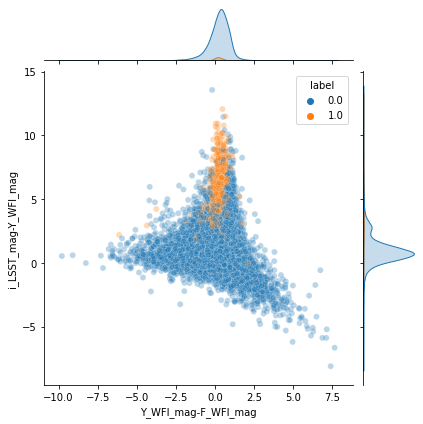

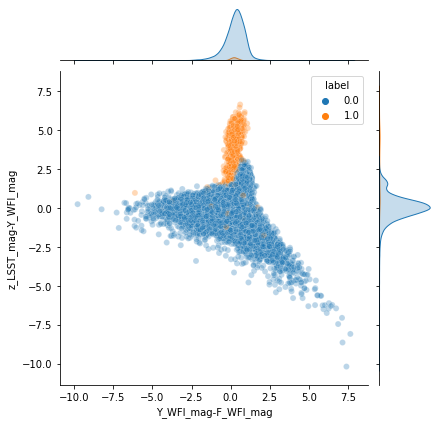

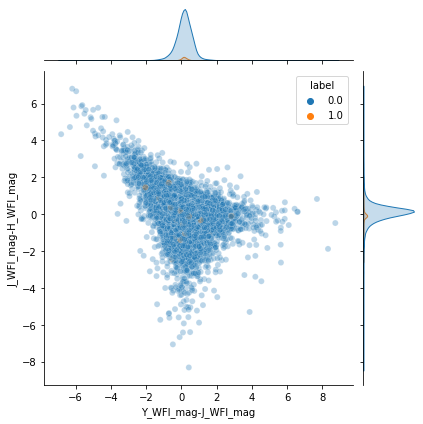

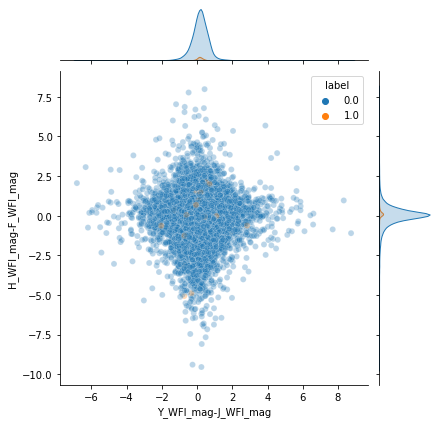

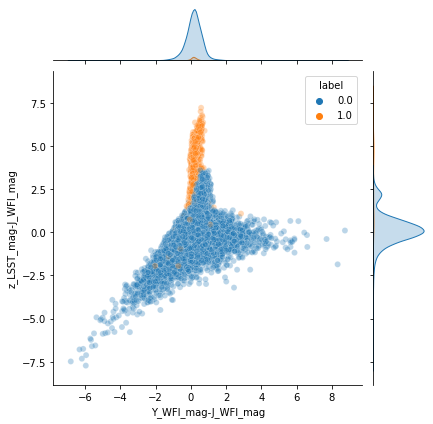

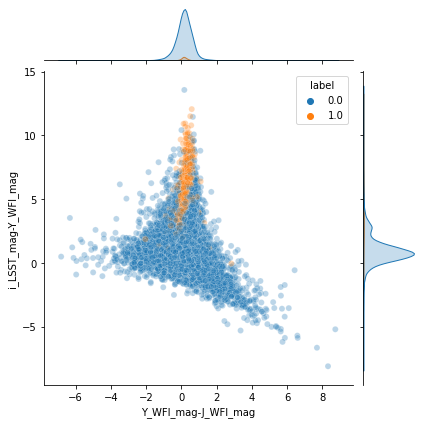

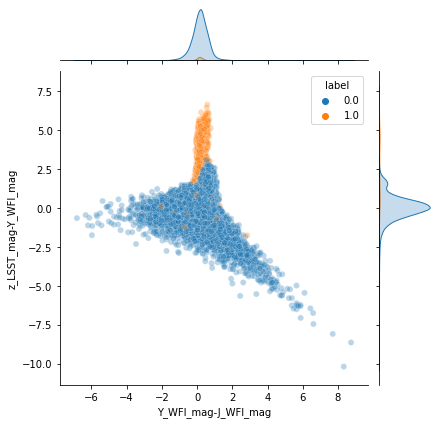

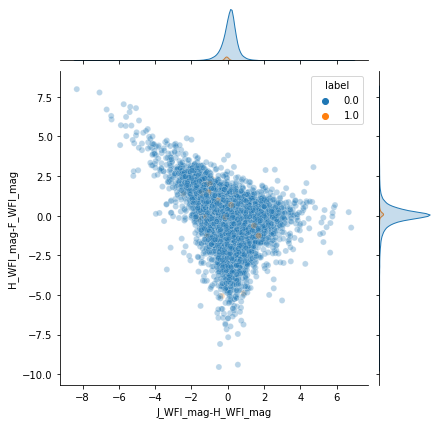

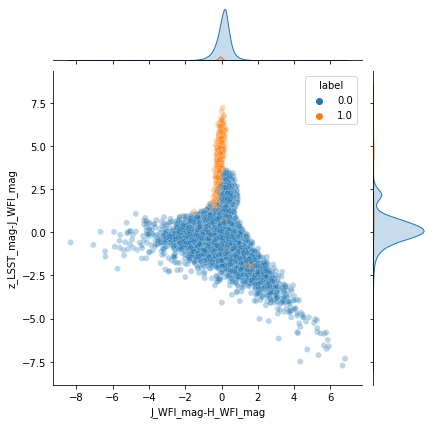

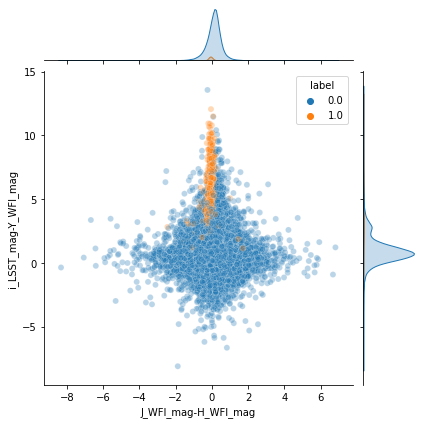

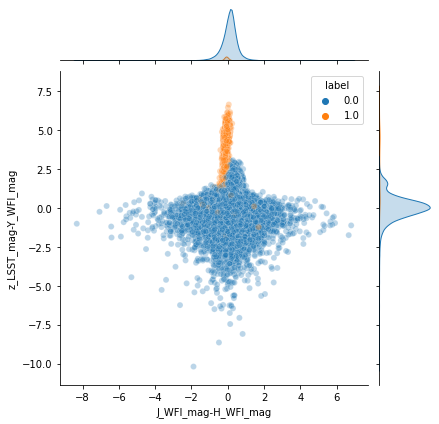

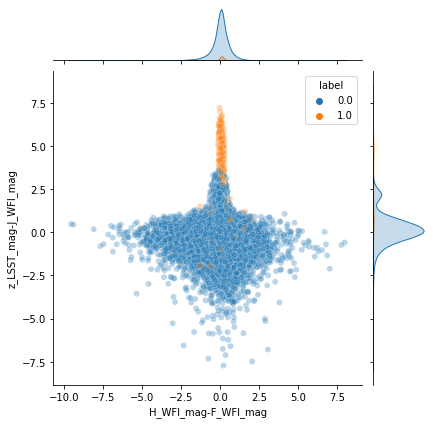

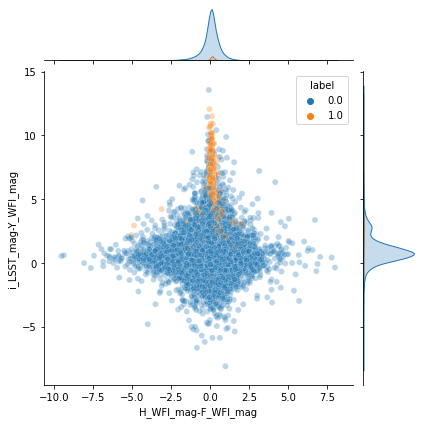

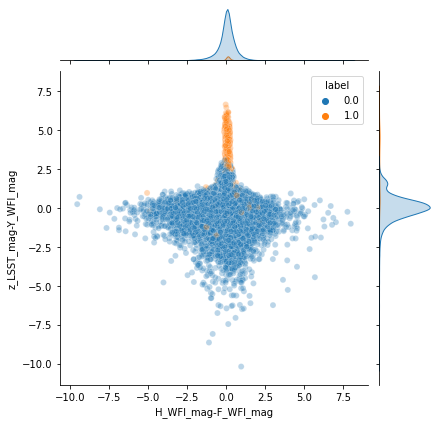

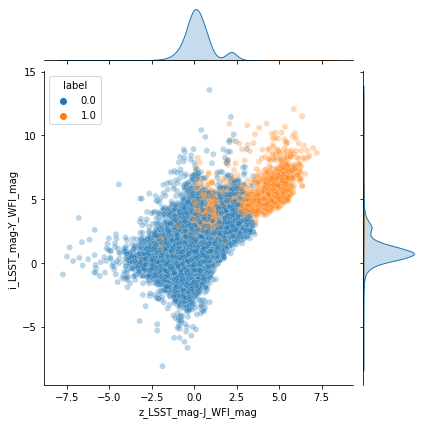

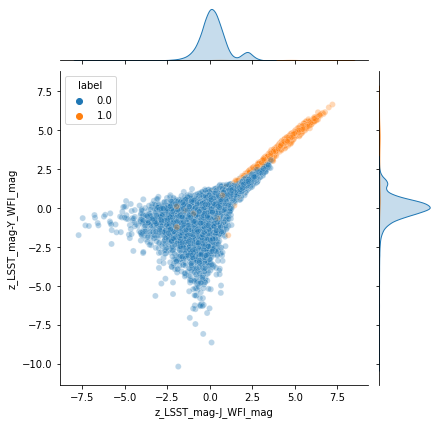

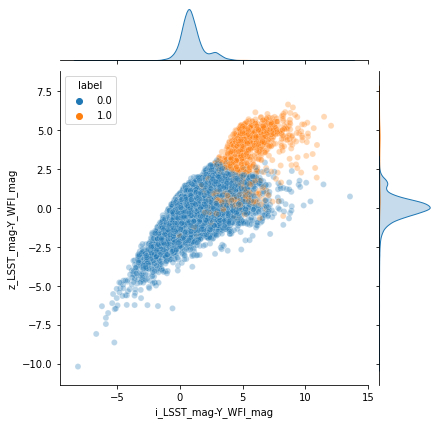

In [45]:
cols = X_drop_copy.columns
# print(len(cols))
sample = X_drop_copy.sample(frac=0.25, replace=False, random_state=42)

for i in range(6, 14):
    x_lab = cols[i]
    # range may change later 
    for j in range(i+1, 14):
        y_lab = cols[j]
        color_plot(sample, x_lab, y_lab)

In [46]:
X_drop_copy = X_drop_copy.drop(columns=['label'])

## try knn

In [16]:
from numba import jit, cuda

In [17]:
@jit(forceobj=True, parallel=True) 
def knn_training(x1, x2, y1, y2, y, n, leaves):
    # format x1: X['r']
    # type: n -> list of integers
    features = [x1-x2, y1-y2]
    X = np.array(features).transpose()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    grid_params = {'n_neighbors' : n,
                   'leaf_size': leaves,
                   'weights' :  ['uniform','distance'],
                   'metric' : ['minkowski','euclidean','manhattan'],
                  'p': [1, 2, 3, 4, 5, 6],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

    gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
    g_res = gs.fit(X_train, y_train)

    print('best score: ', g_res.best_score_)
    print('best params: ', g_res.best_params_)

In [18]:
def get_color_filter(clf, n_neighbors, weights, x1, x2, y1, y2, y):
    # Create color maps
    cmap_light = ListedColormap(['#75aff9', '#f7a844']) # blue, orange
    cmap_bold = ListedColormap(['#8dbcf9', '#f5a844']) 
    
    features = [x1-x2, y1-y2]
    X = np.array(features).transpose()

    # we create an instance of Neighbours Classifier and fit the data.
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = min(x1 - x2) - 1, max(x1 - x2) + 1
    y_min, y_max = min(y1 - y2) - 1, max(y1 - y2) + 1
    h = (x_max-x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.15)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, alpha=0.2)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.title("k = %i, weights = '%s'"
              % (n_neighbors, weights))

x: Y - F
y : z- J <br>
x: z - J
y: i - Y <br>
x: i - Y
y: z - Y

In [ ]:
# x: Y - F
# y: z - J
knn_training(X_drop_copy['Y_WFI_mag'], X_drop_copy['F_WFI_mag'], X_drop_copy['z_LSST_mag'], X_drop_copy['J_WFI_mag'], Y_drop, [26, 30, 36, 41, 47], [3, 5])
'''
filter2a = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=13, leaf_size=3, weights='uniform', p=3)
get_color_filter(filter2a, 13, 'uniform', X_drop_copy['Y_WFI_mag'], X_drop_copy['F_WFI_mag'], X_drop_copy['z_LSST_mag'], X_drop_copy['J_WFI_mag'], Y_drop)
plt.xlabel('Y_WFI_mag-F_WFI_mag')
plt.ylabel('z_LSST_mag-J_WFI_mag')
plt.show()
'''

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
